# FeedForward Neural Network

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorboard.plugins import projector
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Dict
import nltk
import os
import optuna
import sys
import pickle
import random
import ast
import math
import optuna
import json
import shap

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

sys.path.append(os.path.abspath("../.."))

# Preprocessing
from src.base_preprocessing import BasePreprocessing
from src.generator.pipelines.bpe_generator_preprocessing import BPEGeneratorPreprocessing
from src.generator.pipelines.autotokenizer_generator_preprocessing import AutotokenizerGeneratorPreprocessing
from src.generator.pipelines.keras_tokenizer_generator_preprocessing import KerasTokenizerGeneratorPreprocessing
from src.generator.pipelines.base_generator_preprocessing import BaseGeneratorPreprocessing
# Models
from src.generator.models.feedforward_nn import BatchFeedForwardNN
from src.generator.models.optimized_feedforward_nn import OptimizedBatchFeedForwardNN

[nltk_data] Downloading package punkt to /home/epita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/epita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ⭐ Base Preprocessing

In [3]:
if not os.path.exists("../../data/preprocessed_recipe.csv"):
    base_preprocessor = BasePreprocessing()
    raw_data = base_preprocessor.load('../../data/RAW_recipes.csv')
    data = base_preprocessor.transform(raw_data)
    data.to_csv("../../data/preprocessed_recipe.csv")
else:
    data = pd.read_csv("../../data/preprocessed_recipe.csv")
data.head()

,Unnamed: 0,id,name,minutes,n_steps,description,n_ingredients,steps_string_standardize,ingredients_text,tags_text,cuisine,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,0,137739,arriba baked squash mexican,55,11,autumn is my favorite time of year to cook! th...,7,make a choic and proceed with recip depend on ...,"['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course...",North America – United States,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,1,31490,breakfast pizza,30,9,this recipe calls for the crust to be prebaked...,6,preheat oven to 103.33 celsius °c press dough ...,"['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course...",North America – United States,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,4,44061,amish tomato ketchup canning,190,5,my dh's amish mother raised him on this recipe...,8,"mix all ingredients& boil for 2 30.0 minute , ...","['tomato juice', 'apple cider vinegar', 'sugar...","['weeknight', 'time-to-make', 'course', 'main-...",North America – United States,352.9,1.0,337.0,23.0,3.0,0.0,28.0
3,5,25274,marinated olive,15,4,my italian mil was thoroughly impressed by my ...,9,toast the fennel seed and lightli crush them p...,"['fennel seeds', 'green olives', 'ripe olives'...","['15-minutes-or-less', 'time-to-make', 'course...",North America – United States,380.7,53.0,7.0,24.0,6.0,24.0,6.0
4,6,67888,barbecued rib,120,10,this recipe is posted by request and was origi...,22,in a medium saucepan combin all the ingredi fo...,"['pork spareribs', 'soy sauce', 'fresh garlic'...","['weeknight', 'time-to-make', 'course', 'main-...",North America – United States,1109.5,83.0,378.0,275.0,96.0,86.0,36.0


## Models

#### Training Process (context of 3)

Input: `<s> ing1 ing2 <STEPS> w1 w2 </s>`

| Sample | Input (`x`)                 | Target token (`y`) |
|------|-----------------------------|--------------|
| x1   | `<s> ing1 ing2`             | `<STEPS>`    |
| x2   | `ing1 ing2 <STEPS>`         | `w1`         |
| x3   | `ing2 <STEPS> w1`           | `w2`         |
| x4   | `<STEPS> w1 w2`             | `</s>`       |

Unknown words are encoded as `<UNKNOWN>`

#### Model Architecture

- One Hot encoding (`vocab_size`)
- Embdedding layer (`vocab_size`, `embedding_dim`)
- Dense layer (`embedding_dim`, `hidden_dim`)
- Dropout (if enabled)
- Dense layer (`hidden_dim`, `vocab_size`)
- Softmax layer (`vocab_size`)

### Simple FFNN

This is a simple feed forward neural network that learns to predict the next token using a fixed context

#### Preprocessing

In [3]:
base_generator_preprocessing = BaseGeneratorPreprocessing()
ingredients, steps = base_generator_preprocessing.fit_transform(data)

#### Training

In [7]:
model = BatchFeedForwardNN()
model.fit(ingredients[:10000], steps[:10000], embedding_dim=32, hidden_dim=64, context=30)
model.save("ffnn_save/ffnn_32_embedding_64_hidden_30_context.keras")

Vocab size is: 59349


/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ w2v_embedding (Embedding)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


2025-05-08 16:18:43.610576: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 50084 which is outside the valid range of [0, 64).  Label values: 36204 33141 5492 31386 9663 38963 21281 25873 35562 17609 49848 7981 28282 50084 275 19072 44892 390 2 29408 29128 16765 7787 10949 460 36851 59 15013 28086 21577 24181 130
2025-05-08 16:18:43.610596: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Received a label value of 50084 which is outside the valid range of [0, 64).  Label values: 36204 33141 5492 31386 9663 38963 21281 25873 35562 17609 49848 7981 28282 50084 275 19072 44892 390 2 29408 29128 16765 7787 10949 460 36851 59 15013 28086 21577 24181 130
	 [[{{function_node __inference_one_step_on_data_1991}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/nix/store/mh6gqjf1w1i6ln1a61psnz0gzdmwrspl-python3-3.11.8/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/nix/store/mh6gqjf1w1i6ln1a61psnz0gzdmwrspl-python3-3.11.8/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/nix/store/mh6gqjf1w1i6ln1a61psnz0gzdmwrspl-python3-3.11.8/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/nix/store/8akpjsgw444pybsflsmzfkrmkcp2q53a-python3-3.11.8-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/nix-shell-1166844-0/ipykernel_1950711/2009293501.py", line 2, in <module>

  File "/home/epita/nlp1/notebooks/generator/feedforward_nn.py", line 110, in fit

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/losses/losses.py", line 2246, in sparse_categorical_crossentropy

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/ops/nn.py", line 1964, in sparse_categorical_crossentropy

  File "/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 50084 which is outside the valid range of [0, 64).  Label values: 36204 33141 5492 31386 9663 38963 21281 25873 35562 17609 49848 7981 28282 50084 275 19072 44892 390 2 29408 29128 16765 7787 10949 460 36851 59 15013 28086 21577 24181 130
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_2026]

#### Evaluate

In [10]:
model = BatchFeedForwardNN()
model.load("ffnn_save/ffnn_32_embedding_64_hidden_30_context.keras")

In [ ]:
pred_steps = model.predict_batch(ingredients[10000:10100])

In [7]:
pred_steps

[['salt and cumin cook for 5.0 minute pure soup add the rest of the bean to the soup combin the cornstarch with 1 0.5 tablespoon of water add the lemon and the cornstarch to the soup cook until thicken',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['garl',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['lemon juic',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt

### FFNN with AutoTokenizer

The AutoTokenizer from hugging face as tokenizer will help reducing the vocabulary size

#### Autotokenizer Preprocessing

In [3]:
autotokenizer_generator_preprocessing = AutotokenizerGeneratorPreprocessing()
ingredients, steps = autotokenizer_generator_preprocessing.fit_transform(data)

In [4]:
print(steps[0])
print(ingredients[0])

['make a choic and proceed with recip depend on size of squash', 'cut into half or fourth remov seed for spici squash', 'drizzl oliv oil or melt butter over each cut squash piec season with mexican season mix ii for sweet squash', 'drizzl melt honey', 'but', 'grate piloncillo over each cut squash piec season with sweet mexican spice mix bake at 176.67 celsius', 'again depend on size', 'for 40.0 minute up to an ho', 'until a fork can easili pierc the skin be care not to burn the squash especi if you opt to use sugar or butter if you feel more comfort', 'cover the squash with aluminum foil the first half ho', 'give or tak', 'of bake if desir', 'season with salt']
['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'but', 'olive oil', 'salt']


#### Training

In [ ]:
model = BatchFeedForwardNN()
model.fit(ingredients[:1000], steps[:1000], embedding_dim=256, hidden_dim=128, context=10, dropout=0.2)
model.save("ffnn_save/autotokenizer_ffnn_256_embedding_128_hidden_10_context.keras")

Vocab size is: 59349


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ w2v_embedding (Embedding)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
6225/6225 ━━━━━━━━━━━━━━━━━━━━ 956s 153ms/step - loss: 10.2542 - sparse_categorical_accuracy: 0.0120 - val_loss: 12.3664 - val_sparse_categorical_accuracy: 0.0131
Epoch 2/10
6225/6225 ━━━━━━━━━━━━━━━━━━━━ 980s 157ms/step - loss: 9.2082 - sparse_categorical_accuracy: 0.0137 - val_loss: 13.9578 - val_sparse_categorical_accuracy: 0.0135
Epoch 3/10
1049/6225 ━━━━━━━━━━━━━━━━━━━━ 14:21 166ms/step - loss: 8.2970 - sparse_categorical_accuracy: 0.0142

#### Evaluate

In [13]:
model = BatchFeedForwardNN()
model.load("ffnn_save/autotokenizer_ffnn_32_embedding_64_hidden_30_context.keras")

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 30], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'w2v_embedding', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 59349, 'output_dim': 32, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 32]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'hidden', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}], 'build_input_shape': [None, 30]}, 'registered_name': None, 'build_config': {'input_shape': [None, 30]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'SparseCategoricalCrossentropy', 'config': {'name': 'sparse_categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'ignore_class': None}, 'registered_name': None}, 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'SparseCategoricalAccuracy', 'config': {'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.core.dense.Dense'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}.

Exception encountered: Error when deserializing class 'Dense' using config={'name': 'output', 'trainable': True, 'dtype': 'float32', 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Could not interpret activation function identifier: {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}

In [9]:
pred_steps = model.predict_batch(ingredients[10000:10100])

ValueError: Model not fitted!

In [7]:
pred_steps

[['salt and cumin cook for 5.0 minute pure soup add the rest of the bean to the soup combin the cornstarch with 1 0.5 tablespoon of water add the lemon and the cornstarch to the soup cook until thicken',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['garl',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['lemon juic',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt

### FFNN with BPE Tokenizer

The BPE tokenizer reduce the number of words but chunk the word into smaller pieces

#### BPE Preprocessing

In [4]:
sample = 1000
bpe_generator_preprocessing = BPEGeneratorPreprocessing(vocab_size=512)
if os.path.exists(f"fffn_save/{bpe_generator_preprocessing.get_savepath('ffnn_save')}"):
    bpe_generator_preprocessing.load(f"fffn_save/{bpe_generator_preprocessing.get_savepath()}")
else:
    bpe_generator_preprocessing.fit(data.iloc[:sample])
ingredients, steps = bpe_generator_preprocessing.transform(data.iloc[:sample])
bpe_generator_preprocessing.save_in_dir("ffnn_save")


FITTING BPE TOKENIZER ON 1000 SAMPLES

  - Processed 100 rows, corpus size: 1534
  - Processed 200 rows, corpus size: 3248
  - Processed 300 rows, corpus size: 4758
  - Processed 400 rows, corpus size: 6269
  - Processed 500 rows, corpus size: 7839
  - Processed 600 rows, corpus size: 9543
  - Processed 700 rows, corpus size: 11095
  - Processed 800 rows, corpus size: 12896
  - Processed 900 rows, corpus size: 14504
Final corpus size: 16079 tokens
Sample corpus entries: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'but']

Training BPE tokenizer...
Building initial word frequencies...
Unique words in corpus: 7492
Top 5 most common words: [('salt', 442), ('on', 290), ('sug', 228), ('but', 209), ('eg', 197)]

Building initial alphabet...
Alphabet size: 44
Initial vocabulary size: 47

Initializing splits (words into characters)...

Starting BPE merge operations...

Iteration 1: Current vocab size = 47
  Computing pair frequencies...
  Best pair: ('e', ' ') with frequency

In [9]:
print(steps[0])
print(ingredients[0])

['ma', 'k', 'e ', 'a', ' ch', 'o', 'ic', ' and', ' p', 'roc', 'eed', ' w', 'it', 'h', ' r', 'ec', 'ip', ' d', 'ep', 'en', 'd ', 'on', ' si', 'z', 'e ', 'of', ' s', 'qu', 'as', 'h', 'c', 'ut', ' i', 'n', 'to', ' h', 'alf', ' o', 'r', ' f', 'our', 'th', ' r', 'em', 'ov', ' s', 'eed', ' f', 'or ', 'sp', 'ic', 'i', ' s', 'qu', 'as', 'h', 'd', 'ri', 'z', 'z', 'l', ' o', 'li', 'v', ' o', 'il', ' o', 'r', ' m', 'el', 't ', 'b', 'ut', 't', 'er', ' o', 'v', 'er', ' e', 'ac', 'h', ' c', 'ut', ' s', 'qu', 'as', 'h', ' pi', 'ec', ' s', 'eas', 'on', ' w', 'it', 'h', ' m', 'ex', 'ic', 'an', ' s', 'eas', 'on', ' m', 'ix', ' i', 'i', ' f', 'or ', 's', 'w', 'ee', 't ', 's', 'qu', 'as', 'h', 'd', 'ri', 'z', 'z', 'l', ' m', 'el', 't ', 'h', 'on', 'ey', 'b', 'ut', 'g', 'ra', 't', 'e ', 'p', 'il', 'on', 'c', 'ill', 'o', ' o', 'v', 'er', ' e', 'ac', 'h', ' c', 'ut', ' s', 'qu', 'as', 'h', ' pi', 'ec', ' s', 'eas', 'on', ' w', 'it', 'h', ' s', 'w', 'ee', 't ', 'm', 'ex', 'ic', 'an', ' sp', 'ic', 'e ', 'm', '

#### Training

In [ ]:
model = BatchFeedForwardNN()
model.fit(ingredients[:1000], steps[:1000], embedding_dim=32, hidden_dim=64, context=3, dropout=0.2, learning_rate=1e-1)
model.save("ffnn_save/bpe_ffnn_32_embedding_64_hidden_3_context.keras")

Vocab size is: 250


/home/epita/nlp1/.venv-tf/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-08 18:40:50.245832: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-08 18:40:50.245851: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-08 18:40:50.245854: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: nixos
2025-05-08 18:40:50.245856: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: nixos
2025-05-08 18:40:50.245957: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported ver

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ w2v_embedding (Embedding)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


2025-05-08 18:40:50.933948: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369700656 exceeds 10% of free system memory.


Epoch 1/10
221212/481382 ━━━━━━━━━━━━━━━━━━━━ 5:46 1ms/step - loss: 5.0230 - sparse_categorical_accuracy: 0.0400

#### Evaluate

In [13]:
model = BatchFeedForwardNN()
model.load("ffnn_save/bpe_ffnn_32_embedding_64_hidden_3_context.keras")

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 30], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'w2v_embedding', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 59349, 'output_dim': 32, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 32]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'hidden', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}], 'build_input_shape': [None, 30]}, 'registered_name': None, 'build_config': {'input_shape': [None, 30]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'SparseCategoricalCrossentropy', 'config': {'name': 'sparse_categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'ignore_class': None}, 'registered_name': None}, 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'SparseCategoricalAccuracy', 'config': {'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.core.dense.Dense'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}.

Exception encountered: Error when deserializing class 'Dense' using config={'name': 'output', 'trainable': True, 'dtype': 'float32', 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Could not interpret activation function identifier: {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}

In [9]:
pred_steps = model.predict_batch(ingredients[10000:10100])

ValueError: Model not fitted!

In [7]:
pred_steps

[['salt and cumin cook for 5.0 minute pure soup add the rest of the bean to the soup combin the cornstarch with 1 0.5 tablespoon of water add the lemon and the cornstarch to the soup cook until thicken',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['garl',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt'],
 ['lemon juic',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt',
  'salt

---

We add a more sophisticated ffnn with:
- normalization / dropout to prevent overiftting
- LR plato detection for better training
- batch prediction for performance

### Optimized FFNN with BPE Tokenizer

#### BPE Preprocessing

In [4]:
sample = 1000
bpe_generator_preprocessing = BPEGeneratorPreprocessing(vocab_size=64)
print(bpe_generator_preprocessing.get_savepath('./'))
if os.path.exists(f"{bpe_generator_preprocessing.get_savepath('./')}.npz"):
    bpe_generator_preprocessing.load(f"{bpe_generator_preprocessing.get_savepath()}")
else:
    bpe_generator_preprocessing.fit(data.iloc[:sample])
ingredients, steps = bpe_generator_preprocessing.transform(data.iloc[:sample])

./bpe_preprocessing_64_vocab_size

FITTING BPE TOKENIZER ON 1000 SAMPLES

  - Processed 100 rows, corpus size: 1534
  - Processed 200 rows, corpus size: 3248
  - Processed 300 rows, corpus size: 4758
  - Processed 400 rows, corpus size: 6269
  - Processed 500 rows, corpus size: 7839
  - Processed 600 rows, corpus size: 9543
  - Processed 700 rows, corpus size: 11095
  - Processed 800 rows, corpus size: 12896
  - Processed 900 rows, corpus size: 14504
Final corpus size: 16079 tokens
Sample corpus entries: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'but']

Training BPE tokenizer...
Building initial word frequencies...
Unique words in corpus: 7492
Top 5 most common words: [('salt', 442), ('on', 290), ('sug', 228), ('but', 209), ('eg', 197)]

Building initial alphabet...
Alphabet size: 44
Initial vocabulary size: 47

Initializing splits (words into characters)...

Starting BPE merge operations...

Iteration 1: Current vocab size = 47
  Computing pair frequencies...
  Be

In [4]:
print(steps[0])
print(ingredients[0])

['ma', 'k', 'e ', 'a', ' ch', 'o', 'ic', ' and', ' p', 'roc', 'eed', ' w', 'it', 'h', ' r', 'ec', 'ip', ' d', 'ep', 'en', 'd ', 'on', ' si', 'z', 'e ', 'of', ' s', 'qu', 'as', 'h', 'c', 'ut', ' i', 'n', 'to', ' h', 'alf', ' o', 'r', ' f', 'our', 'th', ' r', 'em', 'ov', ' s', 'eed', ' f', 'or ', 'sp', 'ic', 'i', ' s', 'qu', 'as', 'h', 'd', 'ri', 'z', 'z', 'l', ' o', 'li', 'v', ' o', 'il', ' o', 'r', ' m', 'el', 't ', 'b', 'ut', 't', 'er', ' o', 'v', 'er', ' e', 'ac', 'h', ' c', 'ut', ' s', 'qu', 'as', 'h', ' pi', 'ec', ' s', 'eas', 'on', ' w', 'it', 'h', ' m', 'ex', 'ic', 'an', ' s', 'eas', 'on', ' m', 'ix', ' i', 'i', ' f', 'or ', 's', 'w', 'ee', 't ', 's', 'qu', 'as', 'h', 'd', 'ri', 'z', 'z', 'l', ' m', 'el', 't ', 'h', 'on', 'ey', 'b', 'ut', 'g', 'ra', 't', 'e ', 'p', 'il', 'on', 'c', 'ill', 'o', ' o', 'v', 'er', ' e', 'ac', 'h', ' c', 'ut', ' s', 'qu', 'as', 'h', ' pi', 'ec', ' s', 'eas', 'on', ' w', 'it', 'h', ' s', 'w', 'ee', 't ', 'm', 'ex', 'ic', 'an', ' sp', 'ic', 'e ', 'm', '

#### Training

In [ ]:
model = OptimizedBatchFeedForwardNN()
model.fit(ingredients[:1000], steps[:1000], embedding_dim=32, hidden_dim=64, context=3, dropout=0.2, learning_rate=1e-1, batch_size=512)
model.save("ffnn_save/bpe_optimized_ffnn_32_embedding_64_hidden_3_context.keras")

#### Evaluate

In [13]:
model = BatchFeedForwardNN()
model.load("ffnn_save/autotokenizer_ffnn_32_embedding_64_hidden_30_context.keras")

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 30], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'w2v_embedding', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 59349, 'output_dim': 32, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 32]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'hidden', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}], 'build_input_shape': [None, 30]}, 'registered_name': None, 'build_config': {'input_shape': [None, 30]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'SparseCategoricalCrossentropy', 'config': {'name': 'sparse_categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'ignore_class': None}, 'registered_name': None}, 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'SparseCategoricalAccuracy', 'config': {'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.core.dense.Dense'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}.

Exception encountered: Error when deserializing class 'Dense' using config={'name': 'output', 'trainable': True, 'dtype': 'float32', 'units': 59349, 'activation': {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Could not interpret activation function identifier: {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139964748708112}, 'axis': -1}, 'registered_name': None}

In [9]:
pred_steps = model.predict_batch(ingredients[10000:10100])

ValueError: Model not fitted!

In [ ]:
pred_steps

### Optimized FFNN with Keras Tokenizer

#### Keras Tokenizer Preprocessing

In [17]:
if not os.path.exists("keras_tokenized_data.npz"):
    keras_generator_preprocessing = KerasTokenizerGeneratorPreprocessing()
    ingredients, steps = keras_generator_preprocessing.fit_transform(data)
    ingredients_array = np.array(ingredients, dtype=object)
    steps_array = np.array(steps, dtype=object)
    np.savez_compressed("ffnn_save/keras_tokenized_data.npz", ingredients=ingredients_array, steps=steps_array)
else:
    data = np.load("keras_tokenized_data.npz", allow_pickle=True)
    ingredients = data['ingredients']
    steps = data['steps']

In [19]:
print(steps[0])
print(ingredients[0])

['make', 'a', 'choic', 'and', 'proceed', 'with', 'recip', 'depend', 'on', 'size', 'of', 'squash', 'cut', 'into', 'half', 'or', 'fourth', 'remov', 'seed', 'for', 'spici', 'squash', 'drizzl', 'oliv', 'oil', 'or', 'melt', 'butter', 'over', 'each', 'cut', 'squash', 'piec', 'season', 'with', 'mexican', 'season', 'mix', 'ii', 'for', 'sweet', 'squash', 'drizzl', 'melt', 'honey', 'but', 'grate', 'piloncillo', 'over', 'each', 'cut', 'squash', 'piec', 'season', 'with', 'sweet', 'mexican', 'spice', 'mix', 'bake', 'at', '176.67', 'celsius', 'again', 'depend', 'on', 'size', 'for', '40.0', 'minute', 'up', 'to', 'an', 'ho', 'until', 'a', 'fork', 'can', 'easili', 'pierc', 'the', 'skin', 'be', 'care', 'not', 'to', 'burn', 'the', 'squash', 'especi', 'if', 'you', 'opt', 'to', 'use', 'sugar', 'or', 'butter', 'if', 'you', 'feel', 'more', 'comfort', 'cover', 'the', 'squash', 'with', 'aluminum', 'foil', 'the', 'first', 'half', 'ho', 'give', 'or', 'tak', 'of', 'bake', 'if', 'desir', 'season', 'with', 'salt']


#### Training

In [5]:
model = OptimizedBatchFeedForwardNN()
model.fit(ingredients[:10000], steps[:10000], embedding_dim=256, hidden_dim=128, context=5, epochs=20, dropout=0.2, batch_size=256, learning_rate=1e-2)
model.save("ffnn_save/kerastok_optimized_ffnn_256_embedding_128_hidden_5_context_1e-2_lr_10000.keras")

Preparing unique context-grams for training...


IndexError: list index out of range

#### Evaluate

In [11]:
model = OptimizedBatchFeedForwardNN()
model.load("ffnn_save/kerastok_optimized_ffnn_256_embedding_128_hidden_5_context_1e-2_lr_10000.keras")

TypeError: Could not locate function 'perplexity'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'perplexity', 'registered_name': 'function'}

In [ ]:
model.evaluate(ingredients, steps)

In [7]:
pred_steps = model.predict(ingredients[100])

I0000 00:00:1746794152.693978 2774027 service.cc:152] XLA service 0x7f1308027da0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746794152.694004 2774027 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-05-09 14:35:52.703507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746794152.907748 2774027 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
print(pred_steps)

[['in', 'a', 'small', 'bowl', 'combin', 'the', 'flour', 'and', 'the', 'salt', 'and', 'the', 'sugar', 'and', 'the', 'sugar', 'and', 'the', 'sugar', 'and'], ['in', 'a', 'bowl', 'with', 'a', 'sharp', 'knife', 'and', 'cut', 'the', 'appl', 'into', '2.54', 'cm', 'piec', 'and', 'place', 'in', 'a', 'bowl'], ['in', 'a', 'small', 'bowl', 'combin', 'the', 'egg', 'and', 'the', 'egg', 'and', 'the', 'egg', 'and', 'the', 'egg', 'and', 'the', 'egg', 'and'], ['in', 'a', 'bowl', 'and', 'add', 'the', 'rest', 'of', 'the', 'ingredi', 'and', 'mix', 'well', 'add', 'the', 'egg', 'and', 'mix', 'well', 'add'], ['in', 'a', 'bowl', 'combin', 'the', 'flour', 'and', 'the', 'salt', 'and', 'the', 'sugar', 'and', 'the', 'sugar', 'and', 'the', 'sugar', 'and', 'the'], ['in', 'the', 'center', 'of', 'the', 'pan', 'and', 'place', 'the', 'chicken', 'in', 'the', 'pan', 'and', 'cook', 'for', 'about', '30.0', 'minute', 'or'], ['in', 'a', 'bowl', 'and', 'add', 'the', 'rest', 'of', 'the', 'ingredi', 'and', 'mix', 'well', 'add', 

## Benchmarks

### Evaluation on 500 random samples

In [6]:
models = [
    "kerastok_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr",
    "kerastok_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr",
    "kerastok_optimized_ffnn_512_embedding_256_hidden_5_context_1e-1_lr",
    "bpe_64_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr",
    "bpe_64_optimized_ffnn_256_embedding_128_hidden_5_context_1e-1_lr",
    "bpe_64_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr",
    "bpe_80_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr",
    "bpe_80_optimized_ffnn_256_embedding_128_hidden_5_context_1e-1_lr",
    "bpe_80_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr"
]
results = []
num_samples = 500

for name in models:
    if "kerastok" in name:
        data = np.load("keras_tokenized_data.npz", allow_pickle=True)
    elif "bpe_64" in name:
        data = np.load("bpe_64_tokenized_data.npz", allow_pickle=True)
    else:
        data = np.load("bpe_80_tokenized_data.npz", allow_pickle=True)
    combined = list(zip(data['ingredients'], data['steps']))
    sampled = random.sample(combined, num_samples)
    X, y = zip(*sampled)
    X, y = list(X), list(y)
    model = OptimizedBatchFeedForwardNN()
    model.load(f"ffnn_save/{name}.keras")
    print(f"\nEvaluating model {name}")
    print(f"{'=' * 30}")
    results.append(model.evaluate(X, y)[1])

    y_pred = model.predict(X)

    sample_indices = random.sample(range(len(X)), min(num_samples, len(X)))
    samples = []
    for idx in sample_indices:
        sample = {
            "ingredients": X[idx],
            "recipe": y[idx],
            "pred_recipe": y_pred[idx]
        }
        samples.append(sample)

    filename = os.path.join(f"ffnn_samples/{name}.json")
    with open(filename, "w") as f:
        json.dump(samples, f, indent=2)
    
    print(f"Created JSON file for model: {name}")


Evaluating model kerastok_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr
Found 44660 unique context-grams
Building sample weights using context gram...
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - loss: 3.2691 - sparse_categorical_accuracy: 0.2103
Created JSON file for model: kerastok_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr

Evaluating model kerastok_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr
Found 52876 unique context-grams
Building sample weights using context gram...
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - loss: 3.6697 - sparse_categorical_accuracy: 0.3132
Created JSON file for model: kerastok_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr

Evaluating model kerastok_optimized_ffnn_512_embedding_256_hidden_5_context_1e-1_lr
Found 54276 unique context-grams
Building sample weights using context gram...
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 649ms/step - loss: 3.8441 - sparse_categorical_accuracy: 0.2796
Created JSON file for model: ke

### Metrics (Coverage BLEU ROUGE)

In [15]:
# For BLEU score calculation
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# For ROUGE score calculation
from rouge import Rouge

def calculate_bleu(reference, candidate):
    smoothing = SmoothingFunction().method1
    bleu_1 = sentence_bleu([reference], candidate, 
                          weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu_2 = sentence_bleu([reference], candidate, 
                          weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu_3 = sentence_bleu([reference], candidate, 
                          weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu_4 = sentence_bleu([reference], candidate, 
                          weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    return {
        "bleu-1": bleu_1,
        "bleu-2": bleu_2,
        "bleu-3": bleu_3,
        "bleu-4": bleu_4
    }

def calculate_rouge(reference, candidate):
    rouge = Rouge()
    max_len = min(len(candidate), len(reference))
    scores = rouge.get_scores(candidate[:max_len], reference[:max_len])[0]
    return {
        "rouge-1": scores["rouge-1"]["f"],
        "rouge-2": scores["rouge-2"]["f"],
        "rouge-l": scores["rouge-l"]["f"]
    }

def calculate_ingredient_coverage(ingredients_list, recipe_text):
    clean_ingredients = [ing.strip("' \"").lower() for ing in ingredients_list]
    mentioned_ingredients = sum(1 for ing in clean_ingredients if ing in ingredients_list)
    coverage = mentioned_ingredients / len(clean_ingredients) if clean_ingredients else 0
    return coverage

models = [
    "kerastok_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr",
    "kerastok_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr",
    "kerastok_optimized_ffnn_512_embedding_256_hidden_5_context_1e-1_lr",
    "bpe_64_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr",
    "bpe_64_optimized_ffnn_256_embedding_128_hidden_5_context_1e-1_lr",
    "bpe_64_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr",
    "bpe_80_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr",
    "bpe_80_optimized_ffnn_256_embedding_128_hidden_5_context_1e-1_lr",
    "bpe_80_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr"
]
num_samples = 500

for name in models:
    bleu_score, rouge_score, coverage = defaultdict(int), defaultdict(int), 0
    with open(f"ffnn_samples/{name}.json") as f:
        data_json = json.load(f)
    for i in range(num_samples):
        X = data_json[i]["ingredients"]
        y = data_json[i]["recipe"]
        y_pred = data_json[i]["pred_recipe"]
        computed_bleu = calculate_bleu(y, y_pred)
        for key in computed_bleu.keys():
            bleu_score[key] += computed_bleu[key]
        computed_rouge = calculate_rouge(y, y_pred)
        for key in computed_rouge.keys():
            rouge_score[key] += computed_rouge[key]
        coverage += calculate_ingredient_coverage(X, y_pred)
    for key in rouge_score.keys():
        rouge_score[key] /= num_samples
    for key in bleu_score.keys():
        bleu_score[key] /= num_samples
    coverage /= num_samples
    print(f"Model {name}")
    print(f"{'=' * 30}")
    print(f"Rouge Score: {rouge_score}")
    print(f"Bleu Score: {bleu_score}")
    print(f"Coverage: {coverage}")

Model kerastok_optimized_ffnn_256_embedding_128_hidden_3_context_1e-1_lr
Rouge Score: defaultdict(<class 'int'>, {'rouge-1': 0.10999999945000012, 'rouge-2': 0.0, 'rouge-l': 0.10999999945000012})
Bleu Score: defaultdict(<class 'int'>, {'bleu-1': 0.04817515474197834, 'bleu-2': 0.013349316229768269, 'bleu-3': 0.005873027505904822, 'bleu-4': 0.0033060016980447776})
Coverage: 1.0
Model kerastok_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr
Rouge Score: defaultdict(<class 'int'>, {'rouge-1': 0.17599999911999997, 'rouge-2': 0.0, 'rouge-l': 0.17599999911999997})
Bleu Score: defaultdict(<class 'int'>, {'bleu-1': 0.10824060500225383, 'bleu-2': 0.03786285749255277, 'bleu-3': 0.016460897868650192, 'bleu-4': 0.008443621578692126})
Coverage: 1.0
Model kerastok_optimized_ffnn_512_embedding_256_hidden_5_context_1e-1_lr
Rouge Score: defaultdict(<class 'int'>, {'rouge-1': 0.15999999920000005, 'rouge-2': 0.0, 'rouge-l': 0.15999999920000005})
Bleu Score: defaultdict(<class 'int'>, {'bleu-1': 0

ValueError: Reference is empty.

### Plotting with Optuna

In [46]:
print(results)

[0.22937235236167908, 0.31775331497192383, 0.2861369550228119, 0.20545276999473572, 0.3073872923851013, 0.15686777234077454, 0.17686501145362854, 0.3220231235027313, 0.47724467515945435]


[I 2025-05-09 17:15:01,402] A new study created in memory with name: no-name-6227b540-7f10-4949-b404-191afdabc561
/tmp/nix-shell-1166844-0/ipykernel_2794810/485416007.py:56: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/tmp/nix-shell-1166844-0/ipykernel_2794810/485416007.py:62: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(
/tmp/nix-shell-1166844-0/ipykernel_2794810/485416007.py:71: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(
[W 2025-05-09 17:15:02,125] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Visualization complete. Check the saved PNG files for analysis.

Summary of Model Performance:
                                               Model  Accuracy tokenizer  \
8  bpe_80_optimized_ffnn_256_embedding_128_hidden...  0.477245    bpe_80   
7  bpe_80_optimized_ffnn_256_embedding_128_hidden...  0.322023    bpe_80   
1  kerastok_optimized_ffnn_256_embedding_128_hidd...  0.317753     keras   
4  bpe_64_optimized_ffnn_256_embedding_128_hidden...  0.307387    bpe_64   
2  kerastok_optimized_ffnn_512_embedding_256_hidd...  0.286137     keras   
0  kerastok_optimized_ffnn_256_embedding_128_hidd...  0.229372     keras   
3  bpe_64_optimized_ffnn_256_embedding_128_hidden...  0.205453    bpe_64   
6  bpe_80_optimized_ffnn_256_embedding_128_hidden...  0.176865    bpe_80   
5  bpe_64_optimized_ffnn_256_embedding_128_hidden...  0.156868    bpe_64   

  embedding_size hidden_size context_size  
8            256         128            8  
7            256         128            5  
1           

<Figure size 1000x600 with 0 Axes>

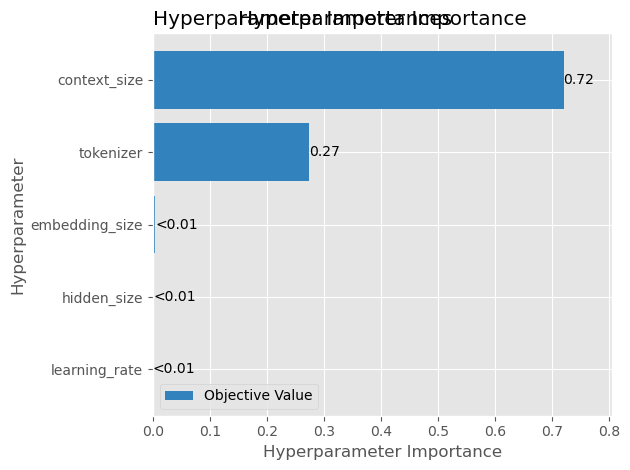

<Figure size 1200x1000 with 0 Axes>

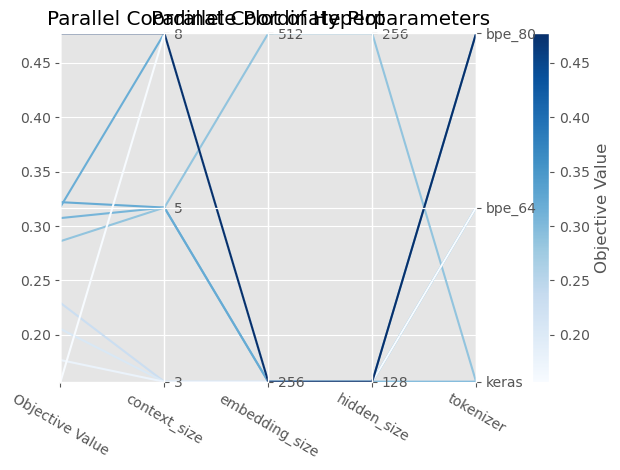

<Figure size 1000x800 with 0 Axes>

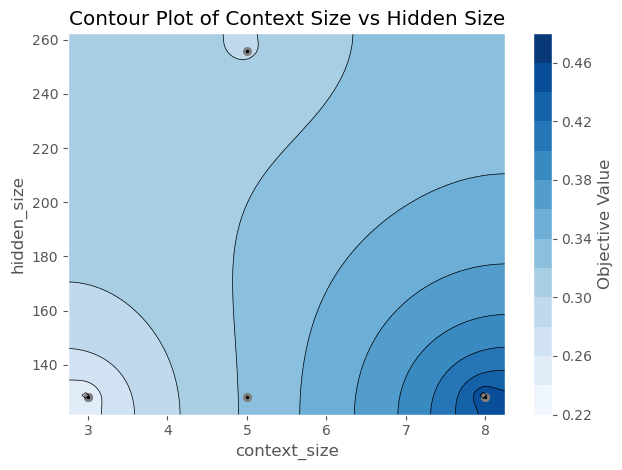

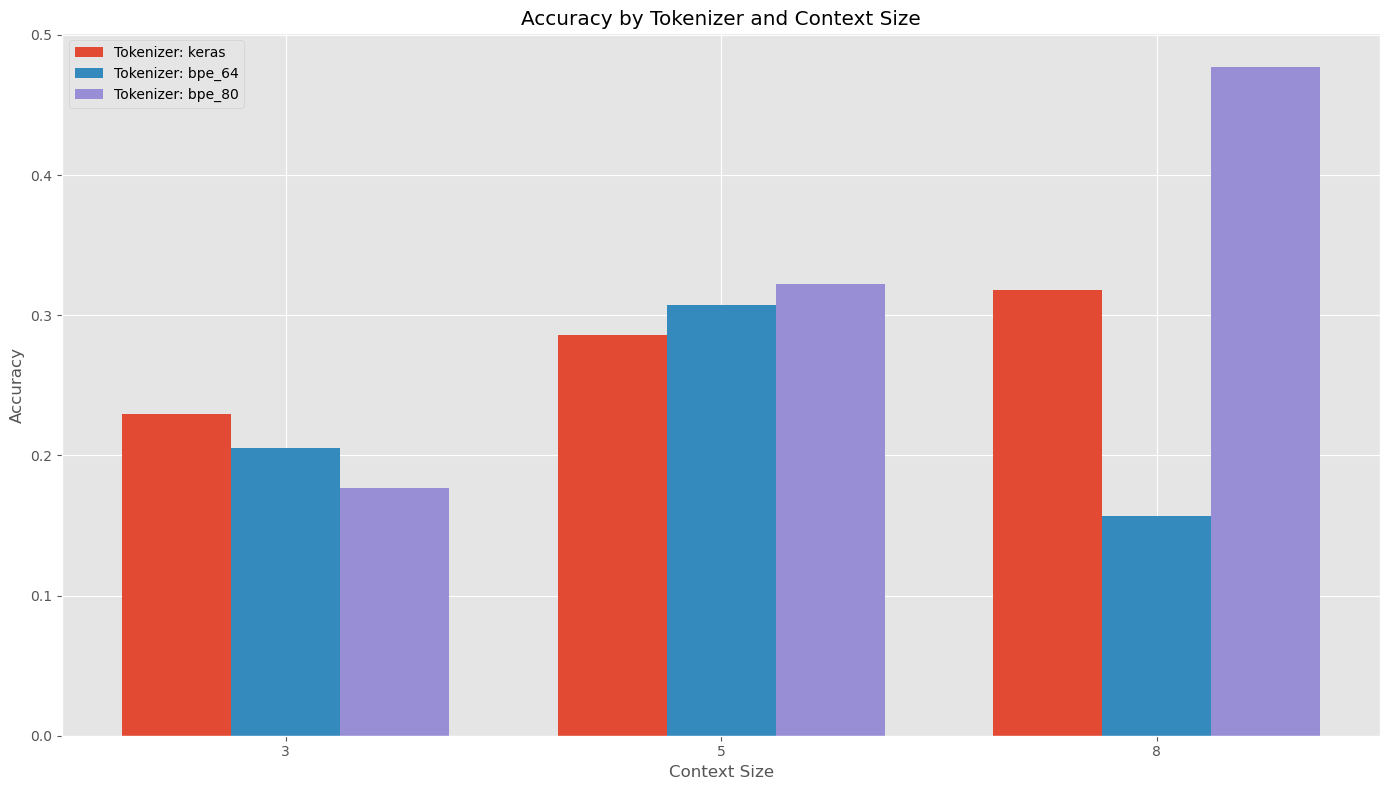

In [47]:
def parse_model_name(name):
    tokenizer = 'keras'
    if 'bpe_64' in name:
        tokenizer = 'bpe_64'
    elif 'bpe_80' in name:
        tokenizer = 'bpe_80'

    embedding_size = int(re.search(r'(\d+)_embedding', name).group(1))
    hidden_size = int(re.search(r'(\d+)_hidden', name).group(1))
    context_size = int(re.search(r'(\d+)_context', name).group(1))
    lr = float(re.search(r'(\d+)e-(\d+)_lr', name).group(0).replace('_lr', ''))
    
    return {
        'tokenizer': tokenizer,
        'embedding_size': embedding_size,
        'hidden_size': hidden_size,
        'context_size': context_size,
        'learning_rate': lr
    }

def create_optuna_study_from_models(model_names, results):
    study = optuna.create_study(direction='maximize')
    
    for i, (name, accuracy) in enumerate(zip(model_names, results)):
        trial = optuna.trial.create_trial(
            params=parse_model_name(name),
            value=accuracy,
            state=optuna.trial.TrialState.COMPLETE,
            distributions={
                'tokenizer': optuna.distributions.CategoricalDistribution(['keras', 'bpe_64', 'bpe_80']),
                'embedding_size': optuna.distributions.CategoricalDistribution([256, 512]),
                'hidden_size': optuna.distributions.CategoricalDistribution([128, 256]),
                'context_size': optuna.distributions.CategoricalDistribution([3, 5, 8]),
                'learning_rate': optuna.distributions.CategoricalDistribution([0.1])
            },
        )
        study.add_trial(trial)
    
    return study

study = create_optuna_study_from_models(model_names, results)

df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': results
})

for i, name in enumerate(model_names):
    params = parse_model_name(name)
    for param_name, param_value in params.items():
        if i == 0:
            df[param_name] = None
        df.at[i, param_name] = param_value

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Hyperparameter Importance')
plt.tight_layout()
plt.savefig('hyperparameter_importance.png')

plt.figure(figsize=(12, 10))
optuna.visualization.matplotlib.plot_parallel_coordinate(
    study, 
    params=['tokenizer', 'embedding_size', 'hidden_size', 'context_size']
)
plt.title('Parallel Coordinate Plot of Hyperparameters')
plt.tight_layout()
plt.savefig('hyperparameter_parallel.png')

plt.figure(figsize=(10, 8))
optuna.visualization.matplotlib.plot_contour(
    study, 
    params=['context_size', 'hidden_size']
)
plt.title('Contour Plot of Context Size vs Hidden Size')
plt.tight_layout()
plt.savefig('contour_plot.png')

plt.figure(figsize=(14, 8))

tokenizers = df['tokenizer'].unique()
context_sizes = sorted(df['context_size'].unique())
width = 0.25
x = np.arange(len(context_sizes))

for i, tokenizer in enumerate(tokenizers):
    accuracies = [df[(df['tokenizer'] == tokenizer) & (df['context_size'] == cs)]['Accuracy'].mean() 
                  for cs in context_sizes]
    plt.bar(x + (i-1)*width, accuracies, width, label=f'Tokenizer: {tokenizer}')

plt.xlabel('Context Size')
plt.ylabel('Accuracy')
plt.title('Accuracy by Tokenizer and Context Size')
plt.xticks(x, context_sizes)
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_by_tokenizer_context.png')

print("Visualization complete. Check the saved PNG files for analysis.")

# Print summary table
print("\nSummary of Model Performance:")
print(df[['Model', 'Accuracy', 'tokenizer', 'embedding_size', 'hidden_size', 'context_size']].sort_values('Accuracy', ascending=False))

## Best Model

In [2]:
model = OptimizedBatchFeedForwardNN()
model.load(f"ffnn_save/kerastok_optimized_ffnn_256_embedding_128_hidden_8_context_1e-1_lr.keras")

2025-05-12 11:36:58.757800: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-12 11:36:58.757839: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-12 11:36:58.757860: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: nixos
2025-05-12 11:36:58.757864: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: nixos
2025-05-12 11:36:58.758050: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program. The library may be missing or provided via another object.
2025-05-12 11:36:58.758087: I external/l

### Embedding Interpretation

In [7]:
log_dir = 'logs/imdb-example'
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'metadata.tsv'), "w", encoding="utf-8") as f:
    for token in model.vocab[1:]:
        f.write(f"{token}\n")

weights = tf.Variable(model.model.get_layer("embedding").get_weights()[0][1:])  # Skip unknown

checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint_path = os.path.join(log_dir, "embedding.ckpt")
checkpoint.save(checkpoint_path)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(log_dir, config)

### SHAP

In [ ]:
if os.path.exists("keras_tokenized_data.npz"):
    data = np.load("keras_tokenized_data.npz", allow_pickle=True)
    ingredients = data['ingredients']
    steps = data['steps']
else:
    raise Exception()

X_train, y_train, sample_weights = model._prepare_train(ingredients[:100], steps[:100])

target_token_id = y_train[0]

class WrappedModel:
    def __init__(self, model, token_id):
        self.model = model
        self.token_id = token_id

    def __call__(self, X):
        preds = self.model.model(X)
        return preds[:, self.token_id]

wrapped_model = WrappedModel(model, token_id=target_token_id)

explainer = shap.Explainer(wrapped_model, masker=shap.maskers.Independent(data=X_train))

shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

Found 10151 unique context-grams
Building sample weights using context gram...


2025-05-12 11:37:12.097313: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4063675648 exceeds 10% of free system memory.
2025-05-12 11:37:12.953183: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4063675648 exceeds 10% of free system memory.


### Comparing with True Values

In [ ]:
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix

# Load data
if os.path.exists("keras_tokenized_data.npz"):
    data = np.load("keras_tokenized_data.npz", allow_pickle=True)
    ingredients_list = data['ingredients']
    steps_list = data['steps']
else:
    raise Exception("Data file not found")

# Parameters
num_samples = 10000
context = model.context
token_to_id = model.token_to_id
id_to_token = model.id_to_token
UNKNOWN = token_to_id.get('<UNKNOWN>')
START = token_to_id.get('<s>')
END = token_to_id.get('</s>')
SEP = token_to_id.get('<STEPS>')

# Set up batch size and initialize results
batch_size = 128
y_true_all = []
y_pred_all = []

# Process each sample in batches
for i in range(0, num_samples, batch_size):
    batch_ingredients = ingredients_list[i:i + batch_size]
    batch_steps = steps_list[i:i + batch_size]

    input_windows = []
    true_token_ids = []

    # Process each sample in the batch
    for j in range(len(batch_ingredients)):
        ingredients = batch_ingredients[j]
        steps = batch_steps[j]

        ingredient_ids = [START] + \
                         [token_to_id.get(tok, UNKNOWN) for tok in ingredients] + \
                         [SEP]
        step_ids = [token_to_id.get(tok, UNKNOWN) for tok in steps] + [END]
        full_sequence = ingredient_ids + step_ids

        # Sliding window over full_sequence
        for k in range(len(full_sequence) - context):
            input_window = full_sequence[k:k + context]
            true_token_id = full_sequence[k + context]
            
            input_windows.append(input_window)
            true_token_ids.append(true_token_id)

    # Convert to numpy array for batch prediction
    input_array = np.array(input_windows, dtype=np.int32)
    probs = model.model.predict(input_array, verbose=0)

    # Extract predictions for the batch
    pred_token_ids = np.argmax(probs, axis=1)

    # Append results
    y_true_all.extend(true_token_ids)
    y_pred_all.extend(pred_token_ids)

conf_matrix = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(10, 10))
plt.scatter(y_true_all, y_pred_all, alpha=0.3, s=10, c='blue')

plt.xlabel('True Token ID')
plt.ylabel('Predicted Token ID')
plt.title('Scatter Plot of Predictions')
plt.grid(True)
plt.tight_layout()
plt.show()